## Market share analysis
Suppose there are 5 manufacturers for a product in the market. The task is to ascertain the market share of each of these manufacturers. For this purpose I created an artificial market with random values. Then I used the following two approaches:
1. `Random Sample` - I drew a random sample of a small size and analyzed the market share based on that.
2. `Markov Chain Monte Carlo` - I ran a simulation using `tensorflow probability` to calculate the market share starting with a reasonable guess of uniform distribution of market share.

The results are compared below. The second approach is useful when sampling is either too expensive or it is impossible. 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [2]:
# Define the market parameters
market_size = int(1e4)
market_players = np.array([i+1 for i in range(5)], dtype='int32') # simple integer enumeration

array = np.random.choice(range(10,100), len(market_players))
market_share = array/sum(array) # fractional distribution
market = np.random.choice(market_players, market_size, replace=True, p=market_share)

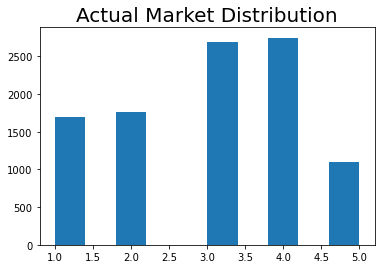

In [3]:
# Visualize the actual market as a histogram
plt.hist(market)
plt.title('Actual Market Distribution', size=20)
plt.show()

In [4]:
# Draw a small random sample
sample_size = 100 
sample = np.random.choice(market, sample_size, replace=True)

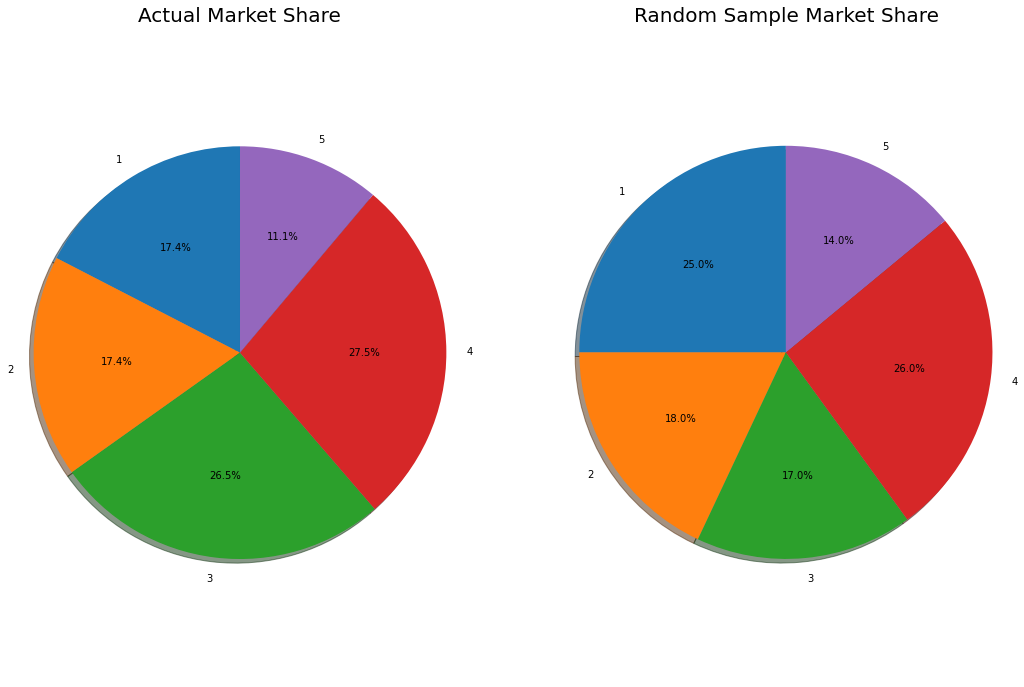

In [5]:
# Pie charts - calculated vs actual (the slices will be ordered and plotted counter-clockwise)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Actual pie chart
labels = market_players
sizes = market_share

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Actual Market Share', size=20)

# Calculated pie chart
labels = market_players
hist = np.histogram(sample, bins=len(market_players))[0]
sizes = hist/sum(hist)

ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Random Sample Market Share', size=20)

plt.show()

In [6]:
# Define initial guess
probs = np.ones(sample_size)*(1/len(market_players)) # equally likely
likelihood = tfd.Bernoulli(probs=probs)

# Option 1
unif_distn = np.random.choice(market_players, sample_size, replace=True)
initial_state=tf.convert_to_tensor(unif_distn, dtype='float32') # reasonable guess - uniform distribution of market share

# Option 2
# initial_state=tf.convert_to_tensor(np.ones(sample_size), dtype='float32') # bad guess - total market dominance by one player

# Option 3
# initial_state=tf.convert_to_tensor(sample, dtype='float32') # informed guess - market share according to random sample

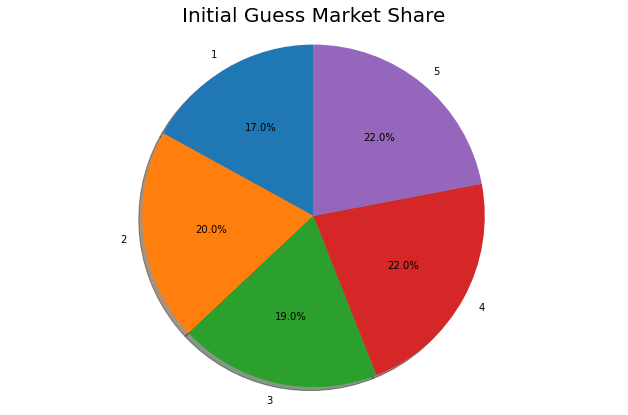

In [7]:
# Pie chart of initial guess (the slices will be ordered and plotted counter-clockwise)
labels = market_players
hist = np.histogram(initial_state, bins=len(market_players))[0]
sizes = hist/sum(hist)

fig, ax = plt.subplots(figsize=(11,7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90, normalize=True)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Initial Guess Market Share', size=20)

plt.show()

In [8]:
# Define MCMC model
n_burnin_steps = int(1e2)
state = initial_state

kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=likelihood.log_prob,
                                        step_size=np.ones(len(initial_state))*0.0005,
                                        num_leapfrog_steps=5)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, 
                                           num_adaptation_steps=int(n_burnin_steps*0.8))

def update_state(state):
    new_state, is_accepted = tfp.mcmc.sample_chain(num_results=1,
                                                   num_burnin_steps=n_burnin_steps,
                                                   current_state=state,
                                                   kernel=kernel,
                                                   trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    new_state = np.asarray(new_state).reshape(initial_state.shape)
    new_state = tf.convert_to_tensor(new_state, dtype='float32')
    return new_state, is_accepted

In [9]:
# Run the simulation
n_steps = 200 # due to limited compute resources
for i in range(n_steps):
    state, is_accepted = update_state(state)
    # print(F'State {i} accepted = {is_accepted}')

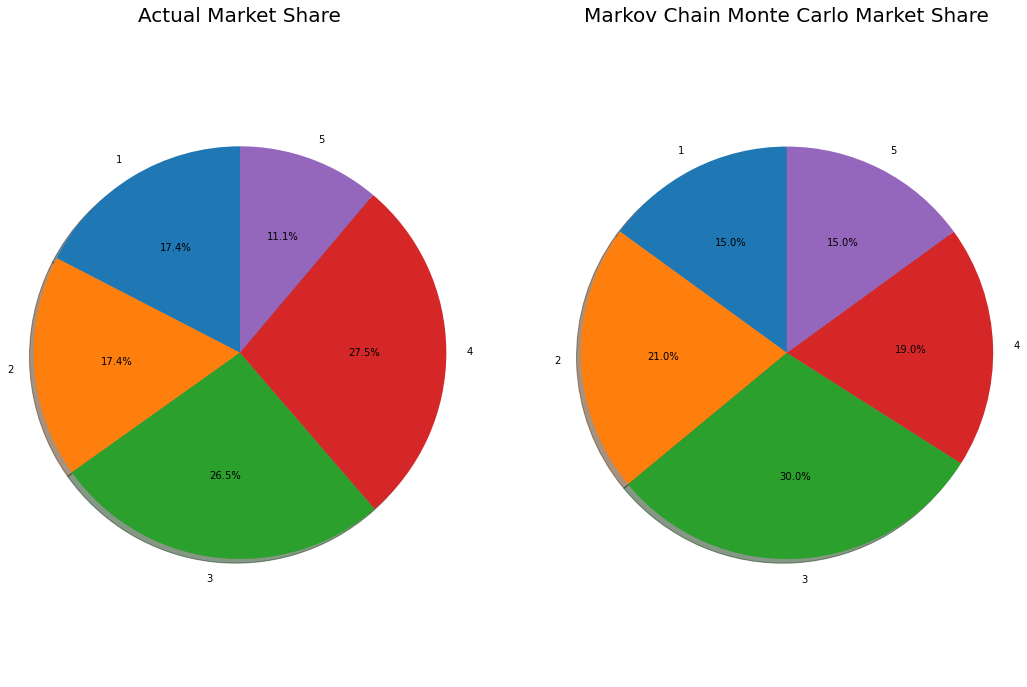

In [10]:
# Pie charts - calculated vs actual (the slices will be ordered and plotted counter-clockwise)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Actual pie chart
labels = market_players
sizes = market_share

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Actual Market Share', size=20)

# Calculated pie chart
labels = market_players
hist = np.histogram(state, bins=len(market_players))[0]
sizes = hist/sum(hist)

ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Markov Chain Monte Carlo Market Share', size=20)

plt.show()